# AUEB M.Sc. in Data Science

- Course: **Deep Learning**

- Semester: Spring 2020

- Instructor: Prof. P Malakasiotis

- Author: S. Politis (p3351814)

- Homework: 1

## Import required libraries and custom packages

In [1]:
import importlib
import logging
import numpy as np
import platform
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import talos
import tensorflow as tf
import tensorflow_addons as tfa
import time

Using TensorFlow backend.


In [2]:
sys.path.append("../code/")

from AUEB.DL.H001 import Examples
from AUEB.DL.H001 import Logger
from AUEB.DL.H001.Data import FashionMNISTReader
from AUEB.DL.H001.Evaluation import Evaluate
from AUEB.DL.H001.Visualization import Visualization
from AUEB.DL.H001.Model import MLP

## Setup globals

In [3]:
# Required for GraphViz.
if platform.system() == "Windows":
    os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin/"
elif platform.system() == "Linux":
    os.environ["PATH"] += os.pathsep + "/usr/lib/x86_64-linux-gnu/graphviz"

log = Logger.create_logger(
    name = "msc-ds-dl-h-001", 
    level = logging.DEBUG
)

class_names = [
    "T-shirt/top", 
    "Trouser", 
    "Pullover", 
    "Dress", 
    "Coat",
    "Sandal", 
    "Shirt", 
    "Sneaker", 
    "Bag", 
    "Ankle boot"
]

Set the *Numpy* and *Tensorflow* seed so that stochasticity in repeated experimentation is removed and results are reproducible, especially when performing hyperparameter tuning.

In [4]:
random_seed = 19730618
np.random.seed(random_seed)
tf.random.set_seed = random_seed

Inspect our environment characteristics:

In [5]:
# Environment characteristics.
log.info(
    f"\n\nTensorflow ver.\t\t{tf.version.VERSION}\nBuilt with CUDA:\t{tf.test.is_built_with_cuda()}\nGPU:\t\t\t{tf.config.list_physical_devices('GPU')}"
)

2020-06-09 19:23:06,196	[INFO]	msc-ds-dl-h-001	<ipython-input-5-07dd36878476>.<module>: 

Tensorflow ver.		2.1.0
Built with CUDA:	True
GPU:			[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Ingest data

In [6]:
X_train, y_train = FashionMNISTReader.load_mnist(path = "../data/fashion",  kind = "train")
X_test, y_test = FashionMNISTReader.load_mnist(path = "../data/fashion",  kind = "t10k")

2020-06-09 19:23:07,112	[INFO]	msc-ds-dl-h-001	FashionMNISTReader.load_mnist: Done loading Fashion-MNIST train data
2020-06-09 19:23:07,152	[INFO]	msc-ds-dl-h-001	FashionMNISTReader.load_mnist: Done loading Fashion-MNIST t10k data


In [7]:
# Data shapes.
log.info(
    f"\n\nDataset shapes\n\nX_train\t{X_train.shape}\ny_train\t{y_train.shape}\nX_test\t{X_test.shape}\ny_test\t{y_test.shape}"
)

2020-06-09 19:23:07,223	[INFO]	msc-ds-dl-h-001	<ipython-input-7-349ebb213b47>.<module>: 

Dataset shapes

X_train	(60000, 784)
y_train	(60000,)
X_test	(10000, 784)
y_test	(10000,)


## Explore data

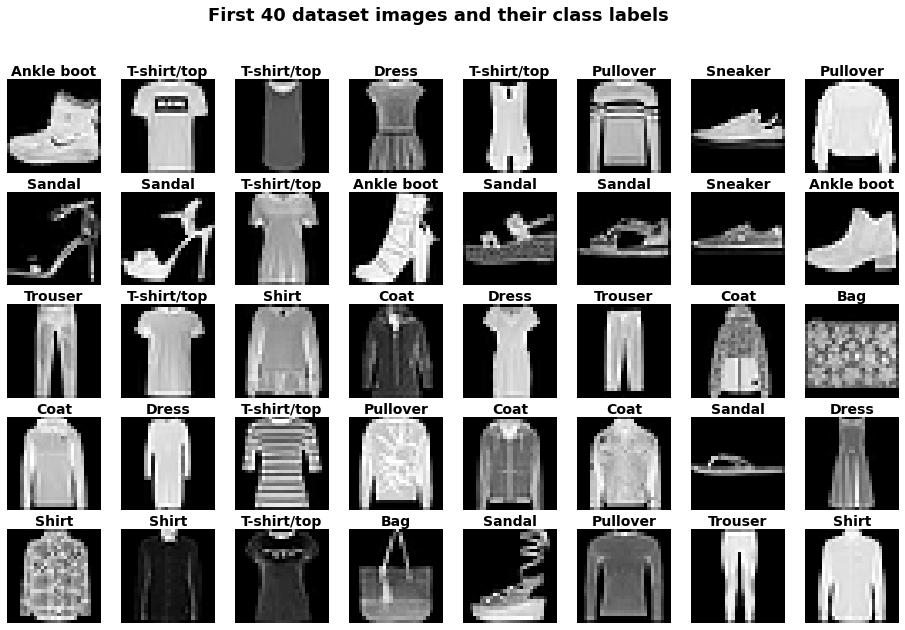

In [8]:
importlib.reload(Visualization)

n_images = 40

Visualization.plot_images(
    data = X_train[0:n_images, :], 
    labels = [class_names[i] for i in y_train[0:n_images]], 
    nrows = 5, 
    title = f"First {n_images} dataset images and their class labels", 
    figsize = (16, 10)
);

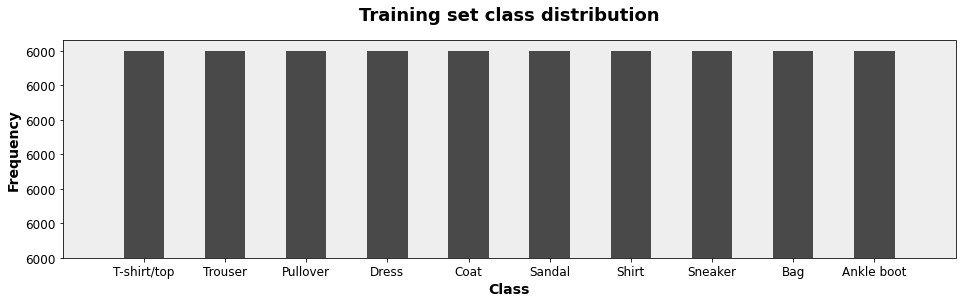

In [9]:
importlib.reload(Visualization)
Visualization.plot_hist(
    data = y_train.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Training set class distribution"
);

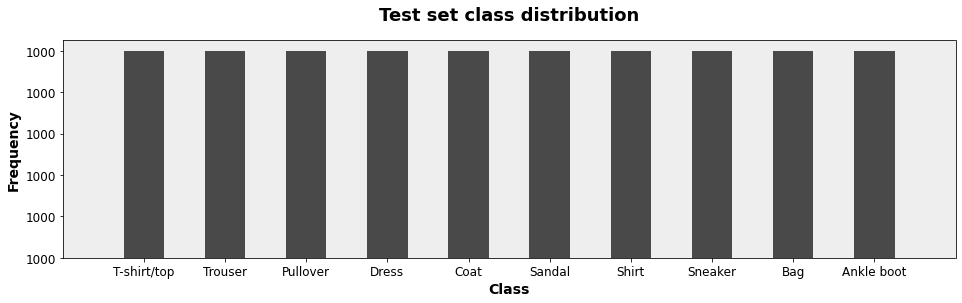

In [10]:
importlib.reload(Visualization)
Visualization.plot_hist(
    data = y_test.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Test set class distribution"
);

We observe that the distribution of classes in both the training and the test set are uniformly distributed, hence the dataset does not present a class imbalance problem.  

## Splitting data into train / dev / test sets

Since our dataset has already been split to train / test sets (*(X_train, y_train)*, *(X_test, y_test)* respectively), we shall proceed further by retaining a percentage ($0.1$) of the training data for creating a development set. The development set will be used for tuning hyperparameters of the model architectures, so as to acquire a robust model for inference.

We shall also be extra careful to retain the uniform nature of the target class distribution so as not to introduce bias. To do this, we shall split the sets in a stratified fashion.

In [12]:
import sklearn.model_selection

X_train, X_dev, y_train, y_dev = sklearn.model_selection.train_test_split(
    X_train, 
    y_train, 
    test_size = 0.2, 
    stratify = y_train, 
    random_state = random_seed, 
    shuffle = True
)

Inspecting the set dimensions:

In [14]:
# Data shapes.
log.info(
    f"\n\nDataset shapes\n\nX_train\t{X_train.shape}\ny_train\t{y_train.shape}\nX_dev\t{X_dev.shape}\ny_dev\t{y_dev.shape}\nX_test\t{X_test.shape}\ny_test\t{y_test.shape}"
)

2020-06-09 19:23:18,551	[INFO]	msc-ds-dl-h-001	<ipython-input-14-7e58ccfaf9ac>.<module>: 

Dataset shapes

X_train	(48000, 784)
y_train	(48000,)
X_dev	(12000, 784)
y_dev	(12000,)
X_test	(10000, 784)
y_test	(10000,)


Inspecting the set target class distributions:

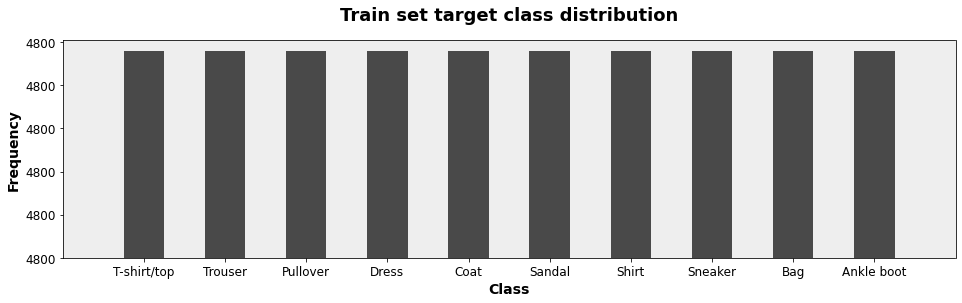

In [15]:
Visualization.plot_hist(
    data = y_train.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Train set target class distribution"
);

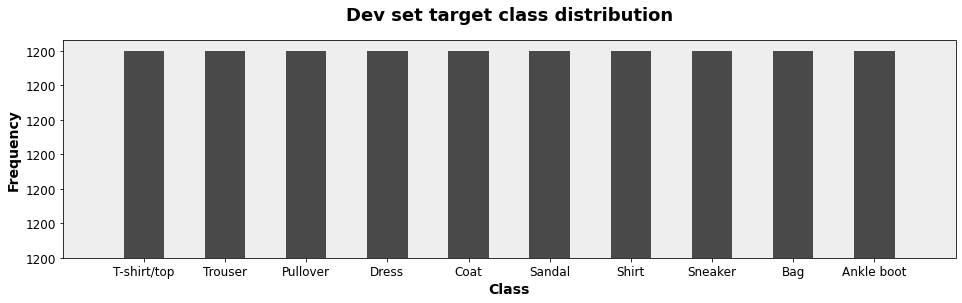

In [16]:
Visualization.plot_hist(
    data = y_dev.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Dev set target class distribution"
);

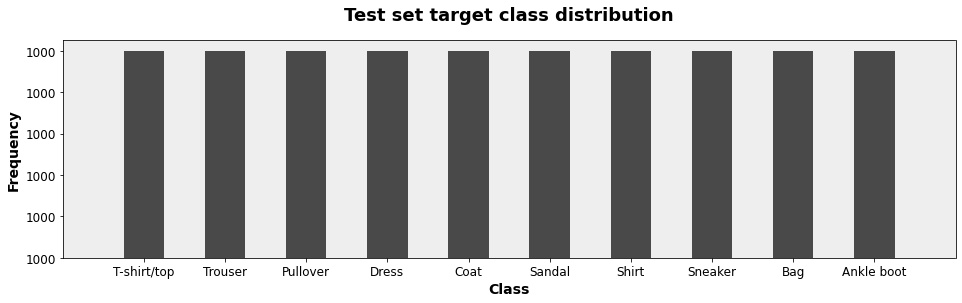

In [17]:
Visualization.plot_hist(
    data = y_test.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Test set target class distribution"
);

## Normalize pixel values

The purpose of normalization is to fit the feature space to $[0, 1]$, because unscaled input variables can result in a slow or unstable learning process.

In [18]:
X_train = X_train / 255
X_dev = X_dev / 255
X_test = X_test / 255

## Classification

### Tensorflow callbacks

#### Early stopping

In [19]:
def early_stopping_callback(
    monitor: str = "val_loss", 
    min_delta = 0, 
    patience = 0
):
    return tf.keras.callbacks.EarlyStopping(
        monitor = monitor, 
        min_delta = min_delta, 
        patience = patience, 
        mode = "auto", 
        verbose = 0
    )

#### TQDM progress bar

In [20]:
def tqdm_callback():
    return tfa.callbacks.TQDMProgressBar()

#### Tensorboard

In [21]:
def tensor_board_callback(model_name:str = None):     
    return tf.keras.callbacks.TensorBoard(
        log_dir = f"logs{os.path.sep}{model_name}", 
        histogram_freq = 0, 
        write_graph = True, 
        write_images = False,
        update_freq = "epoch", 
        profile_batch = 2, 
        embeddings_freq = 0,
        embeddings_metadata = None
    )

### Experiments

The strategy is starting off from a baseline model and possibly identify better results by refining it architecture, going forward.

We shall explore a MLP architecture.

#### MLP

In [22]:
mlp = MLP.MLP(random_seed = random_seed)

##### A small MLP (1 hidden layer, 128 units)

In [23]:
model_name = f"fashion-mnist-mlp-small-he-relu{int(time.time())}"

mlp_small = mlp.create(
    model_name = model_name, 
    input_shape = (784, ), 
    hidden_layers_spec = [
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        }
    ], 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [24]:
mlp_small.summary()

Model: "fashion-mnist-mlp-small-he-relu1591719808"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


##### A medium MLP (2 hidden layers, 128 units)

In [25]:
model_name = f"fashion-mnist-mlp-medium-he-relu{int(time.time())}"

mlp_medium = mlp.create(
    model_name = model_name, 
    input_shape = (784, ), 
    hidden_layers_spec = [
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        },  
    ], 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [26]:
mlp_medium.summary()

Model: "fashion-mnist-mlp-medium-he-relu1591719809"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


##### A large MLP (3 hidden layers, 128 units)

In [27]:
model_name = f"fashion-mnist-mlp-large-he-relu{int(time.time())}"

mlp_large = mlp.create(
    model_name = model_name, 
    input_shape = (784, ), 
    hidden_layers_spec = [
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        }, 
    ], 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [28]:
mlp_large.summary()

Model: "fashion-mnist-mlp-large-he-relu1591719811"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [29]:
mlps = {
    "mlp_small": mlp_small,
    "mlp_medium": mlp_medium,
    "mlp_large": mlp_large
}

##### Training the MLPs with different optimizers

###### SGD

In [30]:
histories = {}

optimizer = tf.keras.optimizers.SGD(
    lr = 0.01, 
    momentum = 0.9, 
    nesterov = True
)

for mlp in mlps.items():
    mlp_label = mlp[0]
    mlp_model = mlp[1]
    
    log.info(f"Training model {mlp_label}")
    
    mlp_model.compile(
        optimizer = optimizer, 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
        metrics = [ 
            "accuracy"
        ]
    )
    
    histories[mlp_label] = mlp_model.fit(
        X_train, 
        y_train, 
        epochs = 100, 
        batch_size = 32, 
        validation_split = 0.1, 
        # validation_data = (X_dev, y_dev), 
        callbacks = [
    #         early_stopping_callback(
    #             monitor = "val_loss", 
    #             patience = 5
    #         ), 
    #        tensor_board_callback(model_name = model_name), 
            tqdm_callback()
        ], 
        verbose = 0
    )

2020-06-09 19:23:33,967	[INFO]	msc-ds-dl-h-001	<ipython-input-30-dfa0f2f84cdc>.<module>: Training model mlp_small


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100



Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100



Epoch 74/100



Epoch 75/100



Epoch 76/100



Epoch 77/100



Epoch 78/100



Epoch 79/100



Epoch 80/100



Epoch 81/100



Epoch 82/100



Epoch 83/100



Epoch 84/100



Epoch 85/100



Epoch 86/100



Epoch 87/100



Epoch 88/100



Epoch 89/100



Epoch 90/100



Epoch 91/100



Epoch 92/100



Epoch 93/100



Epoch 94/100



Epoch 95/100



Epoch 96/100



Epoch 97/100



Epoch 98/100



Epoch 99/100



Epoch 100/100


2020-06-09 19:26:37,999	[INFO]	msc-ds-dl-h-001	<ipython-input-30-dfa0f2f84cdc>.<module>: Training model mlp_medium


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100



Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100



Epoch 74/100



Epoch 75/100



Epoch 76/100



Epoch 77/100



Epoch 78/100



Epoch 79/100



Epoch 80/100



Epoch 81/100



Epoch 82/100



Epoch 83/100



Epoch 84/100



Epoch 85/100



Epoch 86/100



Epoch 87/100



Epoch 88/100



Epoch 89/100



Epoch 90/100



Epoch 91/100



Epoch 92/100



Epoch 93/100



Epoch 94/100



Epoch 95/100



Epoch 96/100



Epoch 97/100



Epoch 98/100



Epoch 99/100



Epoch 100/100


2020-06-09 19:30:01,487	[INFO]	msc-ds-dl-h-001	<ipython-input-30-dfa0f2f84cdc>.<module>: Training model mlp_large


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100



Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100



Epoch 74/100



Epoch 75/100



Epoch 76/100



Epoch 77/100



Epoch 78/100



Epoch 79/100



Epoch 80/100



Epoch 81/100



Epoch 82/100



Epoch 83/100



Epoch 84/100



Epoch 85/100



Epoch 86/100



Epoch 87/100



Epoch 88/100



Epoch 89/100



Epoch 90/100



Epoch 91/100



Epoch 92/100



Epoch 93/100



Epoch 94/100



Epoch 95/100



Epoch 96/100



Epoch 97/100



Epoch 98/100



Epoch 99/100



Epoch 100/100


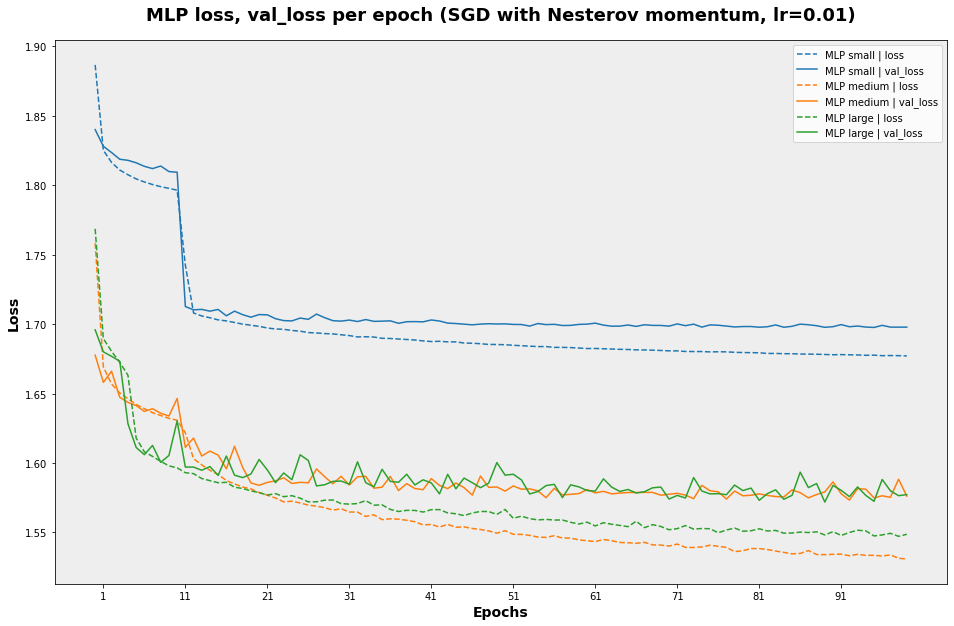

In [31]:
Visualization.plot_training_history(
    histories = {
        "MLP small |": histories["mlp_small"], 
        "MLP medium |": histories["mlp_medium"], 
        "MLP large |": histories["mlp_large"], 
    }, 
    metrics = ["loss", "val_loss"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "MLP loss, val_loss per epoch (SGD with Nesterov momentum, lr=0.01)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

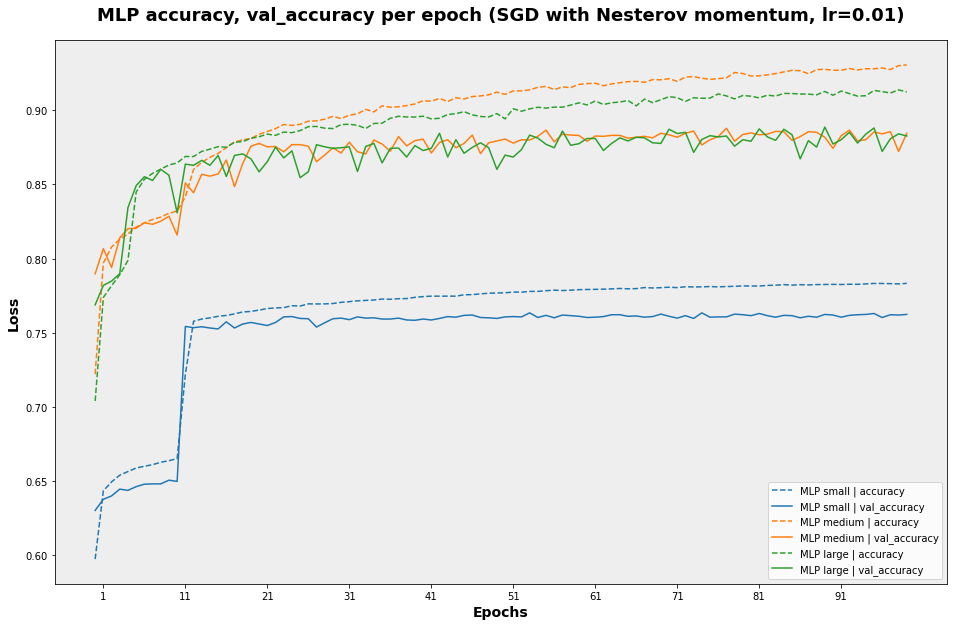

In [32]:
importlib.reload(Visualization)
Visualization.plot_training_history(
    histories = {
        "MLP small |": histories["mlp_small"], 
        "MLP medium |": histories["mlp_medium"], 
        "MLP large |": histories["mlp_large"], 
    }, 
    metrics = ["accuracy", "val_accuracy"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "MLP accuracy, val_accuracy per epoch (SGD with Nesterov momentum, lr=0.01)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

In [33]:
Evaluate.Evaluate().evaluate(histories, X_test, y_test).to_df()

10000/10000 [==============================] - 0s 43us/sample - loss: 1.5855 - accuracy: 0.8752


,test_loss,test_accuracy
mlp_small,1.701778,0.7587
mlp_medium,1.583184,0.8784
mlp_large,1.585485,0.8752


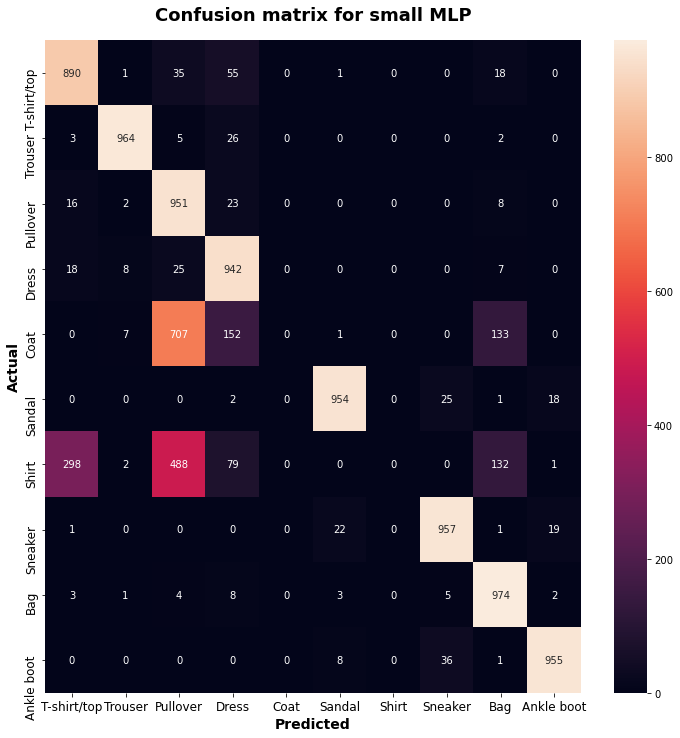

In [34]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = mlp_small.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for small MLP", 
    figsize = (12, 12)
)

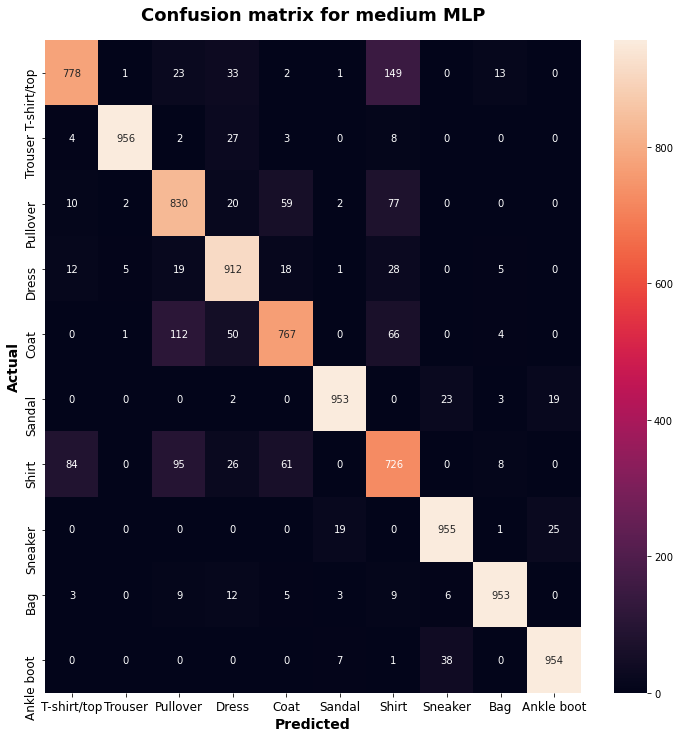

In [35]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = mlp_medium.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for medium MLP", 
    figsize = (12, 12)
)

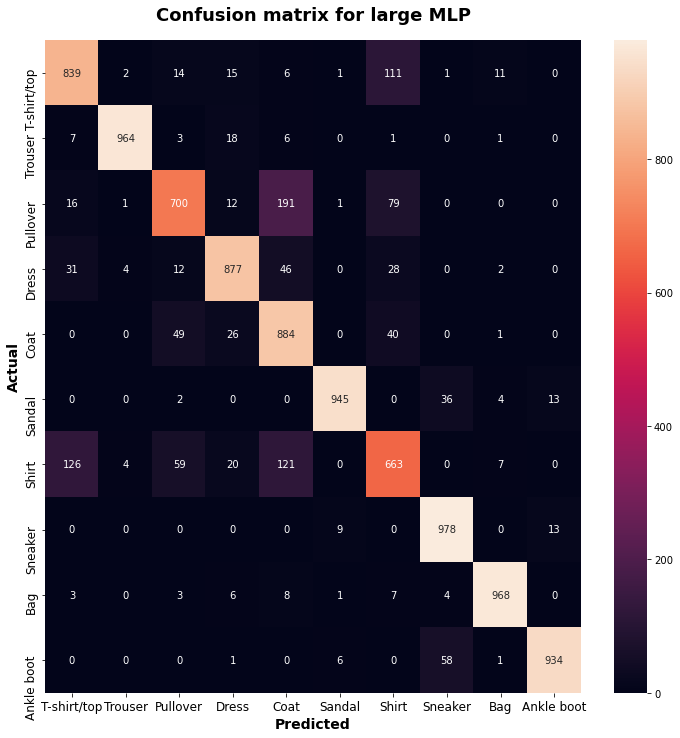

In [36]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = mlp_large.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for large MLP", 
    figsize = (12, 12)
)

###### Adam

In [37]:
histories = {}

optimizer = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001,
        decay_steps = (X_train.shape[0] / 32) * 1000, 
      decay_rate = 1,
      staircase = False
    )
)

for mlp in mlps.items():
    mlp_label = mlp[0]
    mlp_model = mlp[1]
    
    log.info(f"Training model {mlp_label}")
    
    mlp_model.compile(
        optimizer = optimizer, 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
        metrics = [
            "accuracy"
        ]
    )
    
    histories[mlp_label] = mlp_model.fit(
        X_train, 
        y_train, 
        epochs = 100, 
        batch_size = 32, 
        validation_split = 0.1, 
        # validation_data = (X_dev, y_dev), 
        callbacks = [
    #         early_stopping_callback(
    #             monitor = "val_loss", 
    #             patience = 5
    #         ), 
    #        tensor_board_callback(model_name = model_name), 
            tqdm_callback()
        ], 
        verbose = 0
    )

2020-06-09 19:33:37,523	[INFO]	msc-ds-dl-h-001	<ipython-input-37-85687a6811f9>.<module>: Training model mlp_small


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100



Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100



Epoch 74/100



Epoch 75/100



Epoch 76/100



Epoch 77/100



Epoch 78/100



Epoch 79/100



Epoch 80/100



Epoch 81/100



Epoch 82/100



Epoch 83/100



Epoch 84/100



Epoch 85/100



Epoch 86/100



Epoch 87/100



Epoch 88/100



Epoch 89/100



Epoch 90/100



Epoch 91/100



Epoch 92/100



Epoch 93/100



Epoch 94/100



Epoch 95/100



Epoch 96/100



Epoch 97/100



Epoch 98/100



Epoch 99/100



Epoch 100/100


2020-06-09 19:36:51,434	[INFO]	msc-ds-dl-h-001	<ipython-input-37-85687a6811f9>.<module>: Training model mlp_medium


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100



Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100



Epoch 74/100



Epoch 75/100



Epoch 76/100



Epoch 77/100



Epoch 78/100



Epoch 79/100



Epoch 80/100



Epoch 81/100



Epoch 82/100



Epoch 83/100



Epoch 84/100



Epoch 85/100



Epoch 86/100



Epoch 87/100



Epoch 88/100



Epoch 89/100



Epoch 90/100



Epoch 91/100



Epoch 92/100



Epoch 93/100



Epoch 94/100



Epoch 95/100



Epoch 96/100



Epoch 97/100



Epoch 98/100



Epoch 99/100



Epoch 100/100


2020-06-09 19:40:21,522	[INFO]	msc-ds-dl-h-001	<ipython-input-37-85687a6811f9>.<module>: Training model mlp_large


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100



Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100



Epoch 74/100



Epoch 75/100



Epoch 76/100



Epoch 77/100



Epoch 78/100



Epoch 79/100



Epoch 80/100



Epoch 81/100



Epoch 82/100



Epoch 83/100



Epoch 84/100



Epoch 85/100



Epoch 86/100



Epoch 87/100



Epoch 88/100



Epoch 89/100



Epoch 90/100



Epoch 91/100



Epoch 92/100



Epoch 93/100



Epoch 94/100



Epoch 95/100



Epoch 96/100



Epoch 97/100



Epoch 98/100



Epoch 99/100



Epoch 100/100


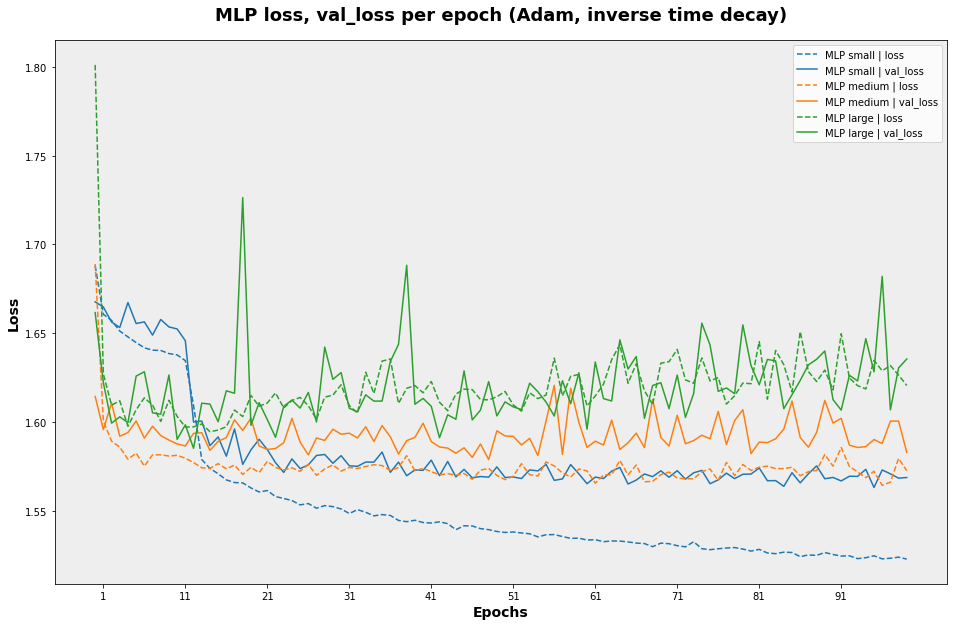

In [38]:
Visualization.plot_training_history(
    histories = {
        "MLP small |": histories["mlp_small"], 
        "MLP medium |": histories["mlp_medium"], 
        "MLP large |": histories["mlp_large"]
    }, 
    metrics = ["loss", "val_loss"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "MLP loss, val_loss per epoch (Adam, inverse time decay)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

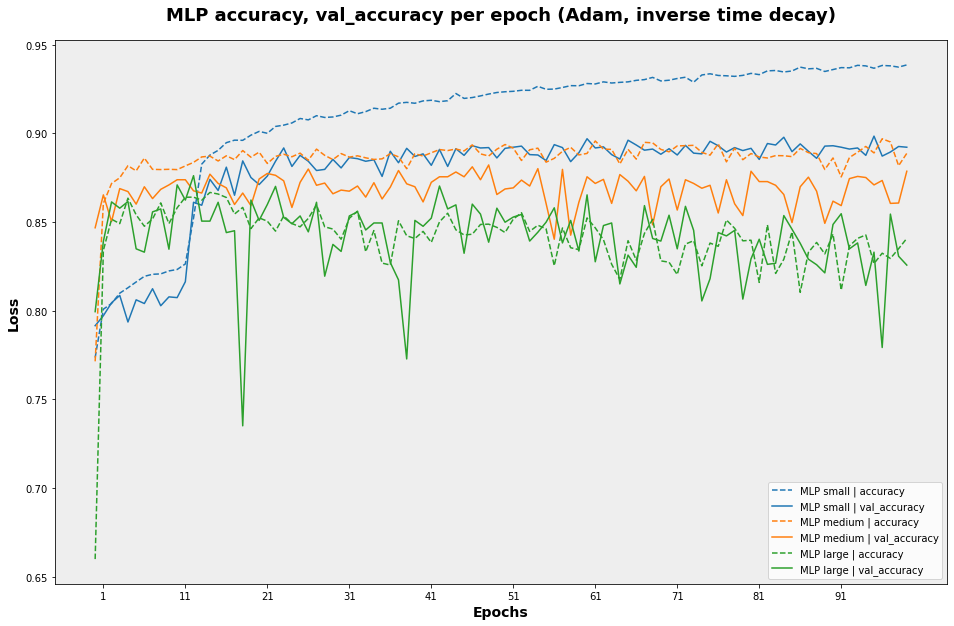

In [39]:
Visualization.plot_training_history(
    histories = {
        "MLP small |": histories["mlp_small"], 
        "MLP medium |": histories["mlp_medium"], 
        "MLP large |": histories["mlp_large"], 
    }, 
    metrics = ["accuracy", "val_accuracy"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "MLP accuracy, val_accuracy per epoch (Adam, inverse time decay)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

In [40]:
Evaluate.Evaluate().evaluate(histories, X_test, y_test).to_df()

10000/10000 [==============================] - 0s 41us/sample - loss: 1.6475 - accuracy: 0.8137


,test_loss,test_accuracy
mlp_small,1.575075,0.8857
mlp_medium,1.592144,0.8690
mlp_large,1.647470,0.8137


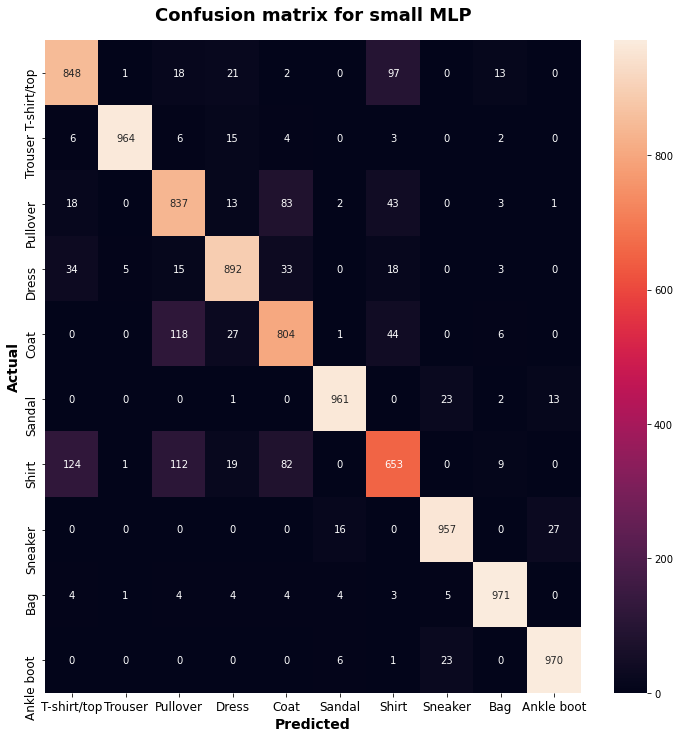

In [41]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = mlp_small.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for small MLP", 
    figsize = (12, 12)
)

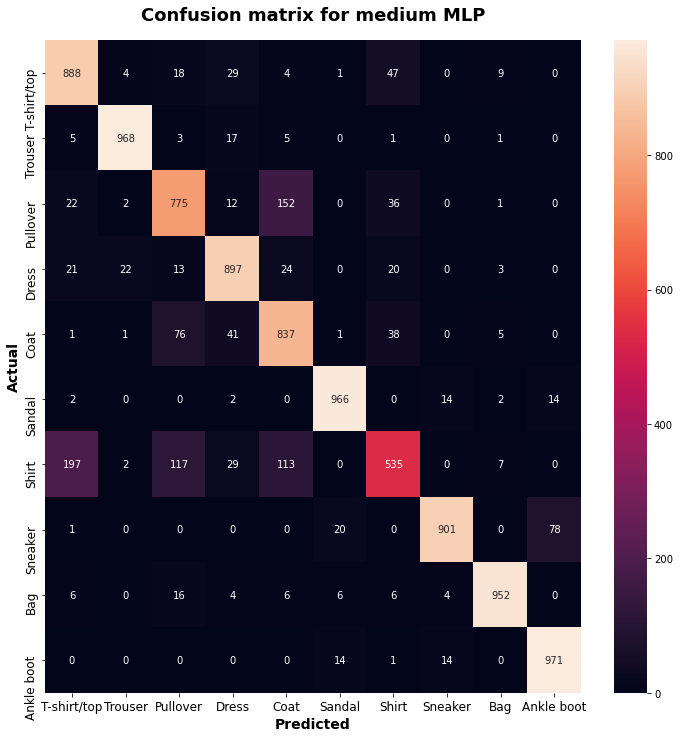

In [42]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = mlp_medium.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for medium MLP", 
    figsize = (12, 12)
)

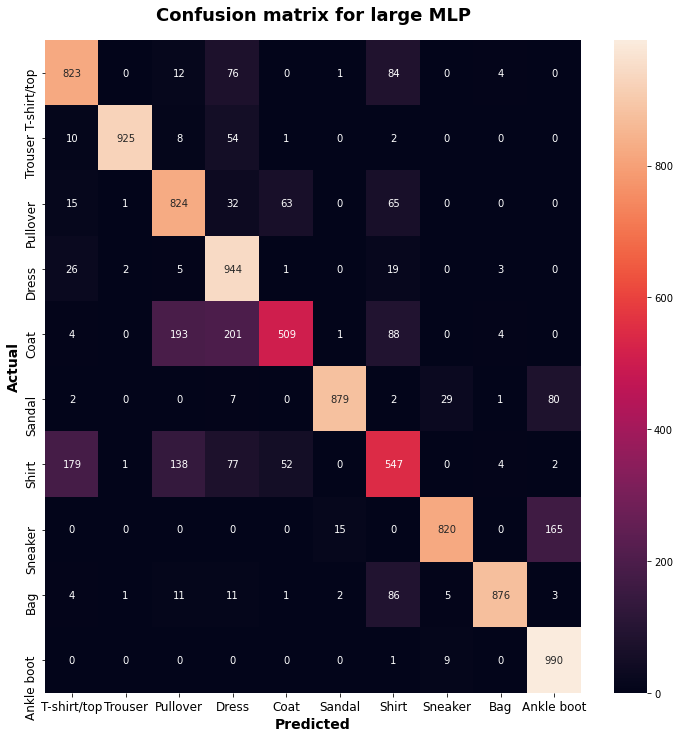

In [43]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = mlp_large.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for large MLP", 
    figsize = (12, 12)
)

#### Introducing regularization with *dropout*

##### A small MLP (1 hidden layer, 128 units)

In [44]:
mlp = MLP.MLP(random_seed = random_seed)

In [45]:
model_name = f"fashion-mnist-mlp-small-he-relu{int(time.time())}"

mlp_small = mlp.create(
    model_name = model_name, 
    input_shape = (784, ), 
    hidden_layers_spec = [
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        }
    ], 
    dropout_layer_spec = {
        "rate": 0.2
    }, 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [46]:
mlp_small.summary()

Model: "fashion-mnist-mlp-small-he-relu1591721032"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


##### A medium MLP (2 hidden layers, 128 units)

In [47]:
model_name = f"fashion-mnist-mlp-medium-he-relu{int(time.time())}"

mlp_medium = mlp.create(
    model_name = model_name, 
    input_shape = (784, ), 
    hidden_layers_spec = [
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        },  
    ], 
    dropout_layer_spec = {
        "rate": 0.2
    }, 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [48]:
mlp_medium.summary()

Model: "fashion-mnist-mlp-medium-he-relu1591721032"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)               0         
_________________________________________________________________
output_layer (Dense)    

##### A large MLP (3 hidden layers, 128 units)

In [49]:
model_name = f"fashion-mnist-mlp-large-he-relu{int(time.time())}"

mlp_large = mlp.create(
    model_name = model_name, 
    input_shape = (784, ), 
    hidden_layers_spec = [
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        }, 
        {
            "units": 128, 
            "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
            "activation": "relu"
        }, 
    ], 
    dropout_layer_spec = {
        "rate": 0.2
    }, 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [50]:
mlp_large.summary()

Model: "fashion-mnist-mlp-large-he-relu1591721032"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_3 (Dense)   

In [51]:
mlps = {
    "mlp_small": mlp_small,
    "mlp_medium": mlp_medium,
    "mlp_large": mlp_large
}

##### Training the MLPs with different optimizers

###### SGD

In [52]:
histories = {}

optimizer = tf.keras.optimizers.SGD(
    lr = 0.01, 
    momentum = 0.9, 
    nesterov = True
)

for mlp in mlps.items():
    mlp_label = mlp[0]
    mlp_model = mlp[1]
    
    log.info(f"Training model {mlp_label}")
    
    mlp_model.compile(
        optimizer = optimizer, 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
        metrics = [ 
            "accuracy"
        ]
    )
    
    histories[mlp_label] = mlp_model.fit(
        X_train, 
        y_train, 
        epochs = 100, 
        batch_size = 32, 
        validation_split = 0.1, 
        # validation_data = (X_dev, y_dev), 
        callbacks = [
            early_stopping_callback(
                monitor = "val_loss", 
                patience = 5
            ), 
    #        tensor_board_callback(model_name = model_name), 
            tqdm_callback()
        ], 
        verbose = 0
    )

2020-06-09 19:43:52,173	[INFO]	msc-ds-dl-h-001	<ipython-input-52-6d611d047fe4>.<module>: Training model mlp_small


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100



Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100


2020-06-09 19:46:10,733	[INFO]	msc-ds-dl-h-001	<ipython-input-52-6d611d047fe4>.<module>: Training model mlp_medium


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100


2020-06-09 19:47:24,227	[INFO]	msc-ds-dl-h-001	<ipython-input-52-6d611d047fe4>.<module>: Training model mlp_large


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100


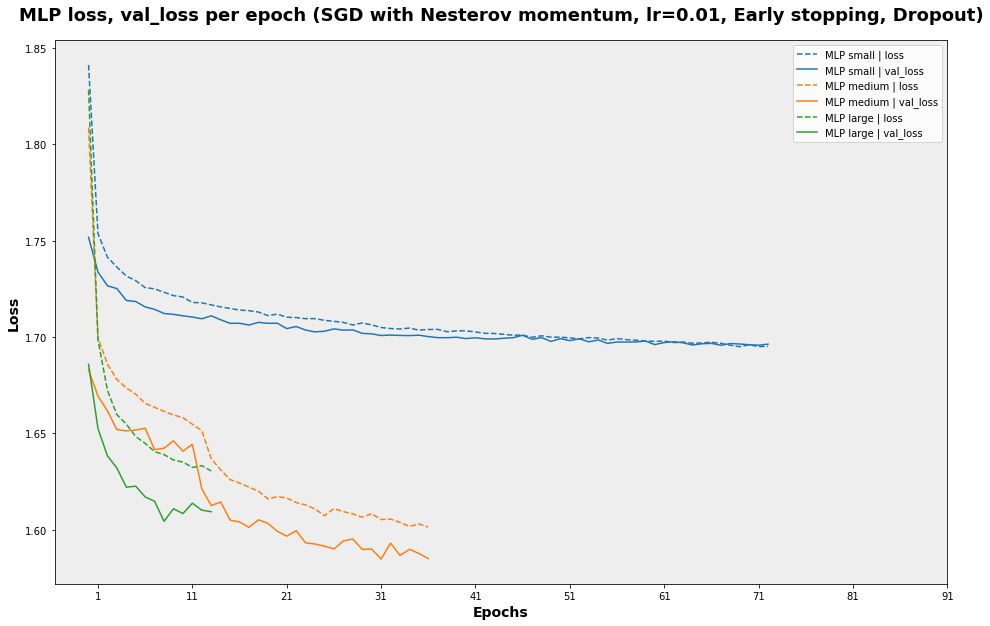

In [53]:
Visualization.plot_training_history(
    histories = {
        "MLP small |": histories["mlp_small"], 
        "MLP medium |": histories["mlp_medium"], 
        "MLP large |": histories["mlp_large"], 
    }, 
    metrics = ["loss", "val_loss"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "MLP loss, val_loss per epoch (SGD with Nesterov momentum, lr=0.01, Early stopping, Dropout)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

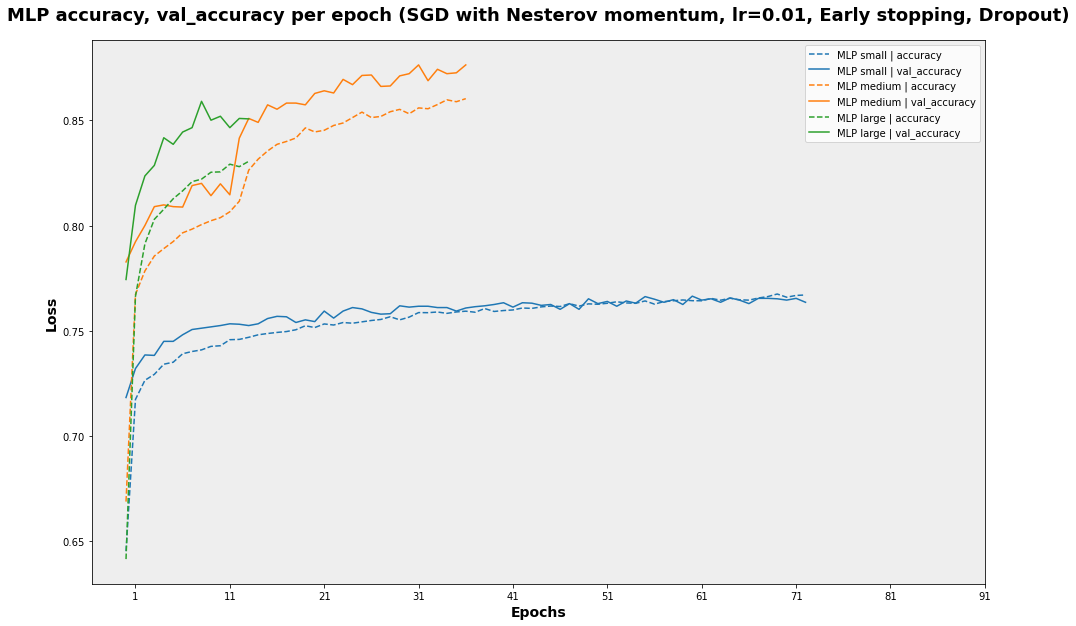

In [54]:
importlib.reload(Visualization)
Visualization.plot_training_history(
    histories = {
        "MLP small |": histories["mlp_small"], 
        "MLP medium |": histories["mlp_medium"], 
        "MLP large |": histories["mlp_large"], 
    }, 
    metrics = ["accuracy", "val_accuracy"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "MLP accuracy, val_accuracy per epoch (SGD with Nesterov momentum, lr=0.01, Early stopping, Dropout)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

In [55]:
Evaluate.Evaluate().evaluate(histories, X_test, y_test).to_df()

10000/10000 [==============================] - 0s 41us/sample - loss: 1.6234 - accuracy: 0.8373


,test_loss,test_accuracy
mlp_small,1.700695,0.7601
mlp_medium,1.596911,0.8645
mlp_large,1.623414,0.8373


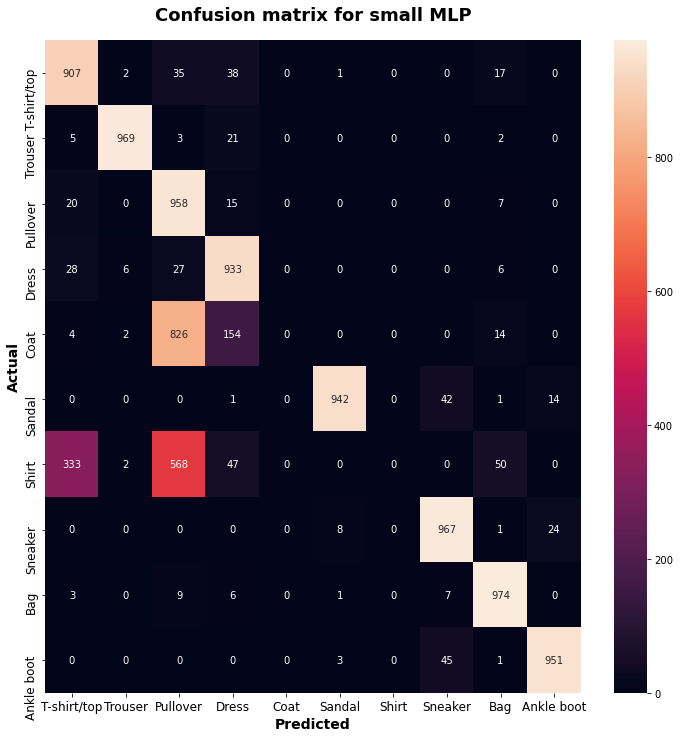

In [56]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = mlp_small.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for small MLP", 
    figsize = (12, 12)
)

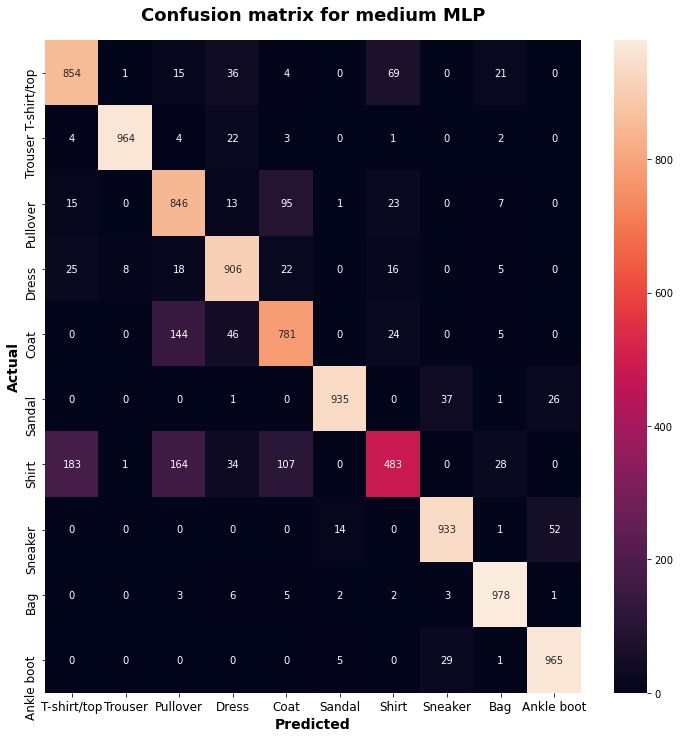

In [57]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = mlp_medium.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for medium MLP", 
    figsize = (12, 12)
)

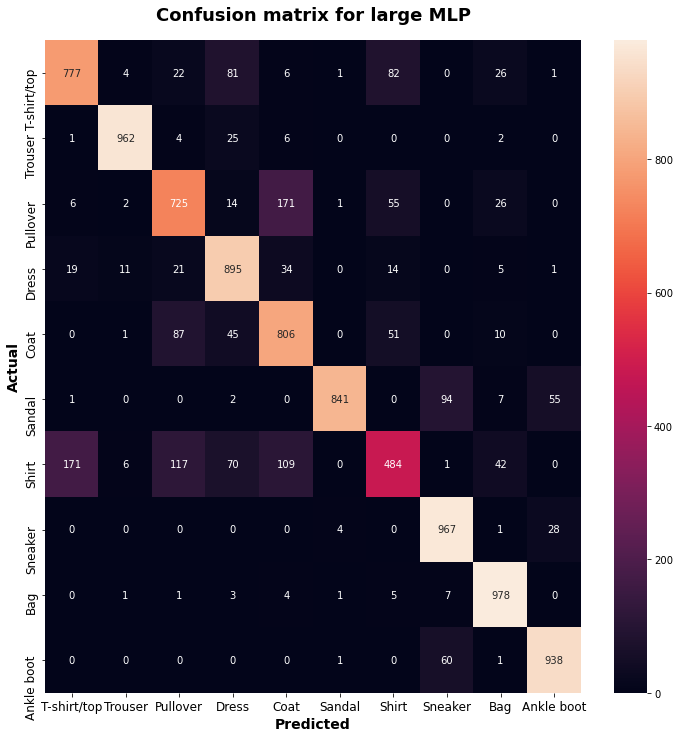

In [58]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = mlp_large.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for large MLP", 
    figsize = (12, 12)
)

#### Hyperparameter tuning of medium MLP with Talos

In [59]:
import talos
from talos.model.early_stopper import early_stopper

In [60]:
# Redefining the MLP generator to work with Talos.
def mlp(X_train, y_train, X_val, y_val, hyperparameters):
    # Input layer (784, )
    input_layer = tf.keras.layers.Input(
        shape = (784, ), 
        name = "input_layer"
    )
    
    l = input_layer

    l = tf.keras.layers.Flatten( 
        name = "flatten_layer_1"
    )(l)

    # Dropout layer
    l = tf.keras.layers.Dropout( 
        rate = hyperparameters["dropout"], 
        name = "dropout_layer_1"
    )(l)

    # 2 fully-connected hidden layers.
    # 1st layer.
    l = tf.keras.layers.Dense(
        units = hyperparameters["first_layer_units"],
        kernel_initializer = hyperparameters["kernel_initializer"],
        activation = hyperparameters["activation"], 
        name = "hidden_layer_1"
    )(l)
    
    # Dropout layer
    l = tf.keras.layers.Dropout( 
        rate = hyperparameters["dropout"], 
        name = "dropout_layer_2"
    )(l)
    
    # Second layer
    l = tf.keras.layers.Dense(
        units = hyperparameters["second_layer_units"],
        kernel_initializer = hyperparameters["kernel_initializer"], 
        activation = hyperparameters["activation"], 
        name = "hidden_layer_2"
    )(l)
    
    # Dropout layer
    l = tf.keras.layers.Dropout( 
        rate = hyperparameters["dropout"], 
        name = "dropout_layer_3"
    )(l)

    output_layer = tf.keras.layers.Dense(
        units = 15, 
        kernel_initializer = hyperparameters["kernel_initializer"], 
        activation = "softmax", 
        name = "output_layer"
    )(l)

    model = tf.keras.models.Model(
        inputs = input_layer, 
        outputs = output_layer, 
        name = "mlp_optimized"
    )
    
    model.compile(
        optimizer = hyperparameters["optimizer"],
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ["acc"]
    )
    
    display(model.summary())
    
    history = model.fit(
        X_train, 
        y_train, 
        epochs = hyperparameters["epochs"],
        validation_data = (X_val, y_val), 
        batch_size = hyperparameters["batch_size"], 
        callbacks = [
            early_stopping_callback(
                monitor = "val_loss", 
                patience = 5
            )
        ], 
        verbose = 0
    )
    
    return history, model

In [61]:
# Define the hyperparameters search space.
hyperparameters = {
    "batch_size": [16, 32, 64], 
    "learning_rate": [0.01, 0.001], 
    "dropout": [0.1, 0.2, 0.3], 
    "first_layer_units": [64, 128, 256], 
    "second_layer_units": [64, 128, 256], 
    "kernel_initializer": [tf.keras.initializers.he_uniform(seed = random_seed)], 
    "activation": [tf.keras.activations.relu], 
    "optimizer": [
        tf.keras.optimizers.SGD(
            lr = 0.01, 
            momentum = 0.9, 
            nesterov = True
        ), 
        tf.keras.optimizers.Adam()
    ], 
    "epochs": [100]
}

# Setup the Talos scan object.
talos_history = talos.Scan(
    x = X_train, 
    y = y_train, 
    x_val = X_dev, 
    y_val = y_dev, 
    params = hyperparameters, 
    model = mlp, 
    # Stochastic grid search downsample.
    fraction_limit = 0.2, 
    experiment_name = "mlp-hyperparameter-tuning", 
    print_params = False
)

  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

  2%|█▎                                                                                 | 1/64 [00:42<44:55, 42.79s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               65792     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

  3%|██▌                                                                                | 2/64 [01:25<44:09, 42.73s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

  5%|███▊                                                                             | 3/64 [03:39<1:11:10, 70.01s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

  6%|█████                                                                            | 4/64 [05:21<1:19:44, 79.74s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               16640     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

  8%|██████▎                                                                          | 5/64 [05:55<1:05:01, 66.12s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

  9%|███████▌                                                                         | 6/64 [07:06<1:05:14, 67.49s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 11%|████████▊                                                                        | 7/64 [08:05<1:01:45, 65.01s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               33024     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 12%|██████████▏                                                                      | 8/64 [09:16<1:02:25, 66.88s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 14%|███████████▋                                                                       | 9/64 [09:51<52:30, 57.27s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 16%|████████████▊                                                                     | 10/64 [10:40<49:06, 54.57s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 17%|█████████████▊                                                                  | 11/64 [12:33<1:03:46, 72.20s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 19%|███████████████                                                                 | 12/64 [13:49<1:03:28, 73.24s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               65792     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 20%|████████████████▎                                                               | 13/64 [15:30<1:09:31, 81.79s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 22%|█████████████████▉                                                                | 14/64 [16:17<59:27, 71.34s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               33024     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 23%|██████████████████▊                                                             | 15/64 [18:58<1:20:07, 98.11s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 25%|████████████████████                                                            | 16/64 [20:07<1:11:29, 89.37s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 27%|█████████████████████▎                                                          | 17/64 [21:51<1:13:24, 93.70s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 28%|██████████████████████▌                                                         | 18/64 [23:14<1:09:22, 90.50s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               65792     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 30%|███████████████████████▊                                                        | 19/64 [24:27<1:03:54, 85.20s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               16640     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 31%|█████████████████████████                                                       | 20/64 [26:11<1:06:47, 91.09s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 33%|██████████████████████████▉                                                       | 21/64 [26:37<51:15, 71.53s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 34%|████████████████████████████▏                                                     | 22/64 [27:22<44:20, 63.36s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 36%|█████████████████████████████▍                                                    | 23/64 [29:26<55:45, 81.60s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 38%|██████████████████████████████▊                                                   | 24/64 [30:27<50:18, 75.46s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 39%|████████████████████████████████                                                  | 25/64 [30:57<40:15, 61.95s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                16448     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 41%|█████████████████████████████████▎                                                | 26/64 [33:30<56:27, 89.15s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                16448     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 42%|██████████████████████████████████▌                                               | 27/64 [34:31<49:48, 80.76s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 44%|███████████████████████████████████▉                                              | 28/64 [35:54<48:46, 81.28s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               16640     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 45%|█████████████████████████████████████▏                                            | 29/64 [36:36<40:41, 69.75s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 47%|██████████████████████████████████████▍                                           | 30/64 [37:45<39:15, 69.27s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 48%|███████████████████████████████████████▋                                          | 31/64 [39:52<47:36, 86.57s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 50%|█████████████████████████████████████████                                         | 32/64 [41:10<44:49, 84.04s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 52%|██████████████████████████████████████████▎                                       | 33/64 [42:32<43:11, 83.59s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 53%|███████████████████████████████████████████▌                                      | 34/64 [42:53<32:22, 64.76s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 55%|███████████████████████████████████████████▏                                   | 35/64 [48:44<1:12:49, 150.66s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 56%|█████████████████████████████████████████████▌                                   | 36/64 [49:44<57:38, 123.51s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                16448     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 58%|██████████████████████████████████████████████▊                                  | 37/64 [50:52<48:03, 106.79s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 59%|████████████████████████████████████████████████▋                                 | 38/64 [51:45<39:20, 90.79s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 61%|█████████████████████████████████████████████████▉                                | 39/64 [52:24<31:18, 75.13s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               33024     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 62%|███████████████████████████████████████████████████▎                              | 40/64 [54:40<37:18, 93.25s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 64%|████████████████████████████████████████████████████▌                             | 41/64 [55:39<31:49, 83.03s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 66%|█████████████████████████████████████████████████████▊                            | 42/64 [56:51<29:16, 79.84s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 67%|█████████████████████████████████████████████████████                          | 43/64 [1:02:46<56:49, 162.34s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 69%|██████████████████████████████████████████████████████▎                        | 44/64 [1:04:58<51:03, 153.17s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 70%|███████████████████████████████████████████████████████▌                       | 45/64 [1:09:10<57:53, 182.83s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 72%|███████████████████████████████████████████████████████▎                     | 46/64 [1:13:47<1:03:17, 210.99s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 73%|████████████████████████████████████████████████████████▌                    | 47/64 [1:17:39<1:01:35, 217.38s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 75%|███████████████████████████████████████████████████████████▎                   | 48/64 [1:20:52<55:59, 209.98s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 77%|████████████████████████████████████████████████████████████▍                  | 49/64 [1:22:46<45:20, 181.36s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 78%|█████████████████████████████████████████████████████████████▋                 | 50/64 [1:25:56<42:56, 184.05s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                16448     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 80%|██████████████████████████████████████████████████████████████▉                | 51/64 [1:29:31<41:51, 193.19s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 81%|████████████████████████████████████████████████████████████████▏              | 52/64 [1:32:18<37:05, 185.42s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 83%|█████████████████████████████████████████████████████████████████▍             | 53/64 [1:37:13<40:01, 218.35s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               16640     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 84%|██████████████████████████████████████████████████████████████████▋            | 54/64 [1:38:49<30:15, 181.51s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               33024     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 86%|███████████████████████████████████████████████████████████████████▉           | 55/64 [1:45:27<36:58, 246.48s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               33024     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 88%|█████████████████████████████████████████████████████████████████████▏         | 56/64 [1:49:49<33:28, 251.07s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               16640     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 89%|██████████████████████████████████████████████████████████████████████▎        | 57/64 [1:52:10<25:25, 217.97s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 91%|███████████████████████████████████████████████████████████████████████▌       | 58/64 [1:52:53<16:33, 165.55s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 128)             

None

 92%|████████████████████████████████████████████████████████████████████████▊      | 59/64 [1:56:05<14:27, 173.48s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                16448     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 94%|██████████████████████████████████████████████████████████████████████████     | 60/64 [1:56:55<09:06, 136.65s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               65792     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 95%|███████████████████████████████████████████████████████████████████████████▎   | 61/64 [1:57:41<05:28, 109.35s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               200960    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               65792     
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 256)             

None

 97%|████████████████████████████████████████████████████████████████████████████▌  | 62/64 [1:59:33<03:40, 110.01s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

 98%|█████████████████████████████████████████████████████████████████████████████▊ | 63/64 [2:02:04<02:02, 122.49s/it]

Model: "mlp_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
flatten_layer_1 (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                50240     
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
dropout_layer_3 (Dropout)    (None, 64)              

None

100%|███████████████████████████████████████████████████████████████████████████████| 64/64 [2:03:11<00:00, 115.48s/it]


In [62]:
talos_report = talos.Reporting(talos_history)
display(talos_report.table(metric = "val_acc").head(5))
display(talos_report.high(metric = "val_acc"))

,dropout,batch_size,learning_rate,duration,second_layer_units,kernel_initializer,round_epochs,val_loss,optimizer,activation,end,epochs,first_layer_units,start,val_acc,acc,loss
33,0.1,64,0.001,20.733557,128,<tensorflow.python.ops.init_ops_v2.VarianceSca...,16,1.947125,<tensorflow.python.keras.optimizer_v2.adam.Ada...,<function relu at 0x000001D4B61489D8>,06/09/20-203556,100,128,06/09/20-203535,0.869833,0.868042,1.948332
1,0.1,64,0.001,42.511617,256,<tensorflow.python.ops.init_ops_v2.VarianceSca...,33,1.947507,<tensorflow.python.keras.optimizer_v2.adam.Ada...,<function relu at 0x000001D4B61489D8>,06/09/20-195428,100,256,06/09/20-195345,0.868750,0.875604,1.940512
0,0.1,64,0.010,42.708029,64,<tensorflow.python.ops.init_ops_v2.VarianceSca...,33,1.950011,<tensorflow.python.keras.optimizer_v2.adam.Ada...,<function relu at 0x000001D4B61489D8>,06/09/20-195345,100,128,06/09/20-195303,0.866417,0.880146,1.935752
45,0.2,32,0.001,276.598058,64,<tensorflow.python.ops.init_ops_v2.VarianceSca...,41,1.950530,<tensorflow.python.keras.optimizer_v2.adam.Ada...,<function relu at 0x000001D4B61489D8>,06/09/20-210649,100,64,06/09/20-210213,0.865750,0.847667,1.968636
37,0.2,32,0.010,53.351535,64,<tensorflow.python.ops.init_ops_v2.VarianceSca...,22,1.954326,<tensorflow.python.keras.optimizer_v2.adam.Ada...,<function relu at 0x000001D4B61489D8>,06/09/20-204448,100,128,06/09/20-204355,0.861333,0.848375,1.967784


0.8698333501815796

In [63]:
best_model = talos_history.best_model()
y_pred = best_model.predict(X_test)

In [64]:
y_pred_classes = np.unique((np.argmax(y_pred, axis = 1) == y_test), return_counts = True)

In [65]:
error, accuracy = y_pred_classes[1] / y_test.shape[0]
accuracy, error

(0.8603, 0.1397)

---